# Applying SAR for snowmelt timing toolbox to Grand Mesa, CO

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
from dask.distributed import Client
import s1_rtc_bs_utils
import py3dep
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import math
import shapely
import matplotlib.pyplot as plt
import os
import xarray as xr
from datetime import datetime
import ulmo
from datetime import datetime
import sys
import contextily as ctx
import rioxarray as rxr
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib
import matplotlib.transforms as mtransforms
import logging
import geopandas as gpd
import requests

In [2]:
#### CODE FOR DEVELOPMENT-- THIS RELOADS s1_rtc_bs_utils MODULE
sys.modules.pop('s1_rtc_bs_utils')
import s1_rtc_bs_utils

In [3]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 
#
xr.set_options(keep_attrs=True)
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False,silence_logs=logging.ERROR)
client

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33641 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.25.45.79:33641/status,
Dashboard: http://172.25.45.79:33641/status,Workers: 1
Total threads: 32,Total memory: 125.71 GiB
Status: running,Using processes: False
Comm: inproc://172.25.45.79/203889/1,Workers: 1
Dashboard: http://172.25.45.79:33641/status,Total threads: 32
Started: Just now,Total memory: 125.71 GiB
Comm: inproc://172.25.45.79/203889/4,Total threads: 32
Dashboard: http://172.25.45.79:46361/status,Memory: 125.71 GiB
Nanny: None,


In [4]:
grandmesa_bbox_gdf = gpd.read_file('shapefiles/grandmesa.geojson')
nm = 'Grand Mesa, CO'
gj = 'shapefiles/grandmesa.geojson'
colls = 'mycollection_grandmesa.json'

In [5]:
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac(grandmesa_bbox_gdf,start_time='2015-01-01',end_time=datetime.today().strftime('%Y-%m-%d'),orbit_direction='all',polarization='gamma0_vv',collection=colls)
ts_ds = ts_ds.compute()
ts_ds = ts_ds.dropna('time',how='all')

In [6]:
ts_ds

<xarray.DataArray 'stackstac-ed9ce822c4af59cc990d9c9b5032c4dc' (time: 139, y: 1278, x: 1524)>
array([[[0.06743611, 0.06719408, 0.08140442, ..., 0.13940993,
         0.14946932, 0.15956731],
        [0.0789023 , 0.07852138, 0.08137354, ..., 0.1291121 ,
         0.13201442, 0.13903536],
        [0.09401289, 0.08817654, 0.08261676, ..., 0.11946211,
         0.12119088, 0.12709263],
        ...,
        [0.08825005, 0.08951563, 0.07989465, ..., 0.28963238,
         0.19918354, 0.21632132],
        [0.09546206, 0.09385803, 0.08523879, ..., 0.3344276 ,
         0.09648466, 0.07496416],
        [0.09492607, 0.09493371, 0.07615872, ..., 0.1622464 ,
         0.05657446, 0.04626776]],

       [[0.03146842, 0.03306774, 0.03446444, ..., 0.18271056,
         0.18757407, 0.20819831],
        [0.03893813, 0.03703857, 0.03220706, ..., 0.16343096,
         0.15829931, 0.17174731],
        [0.05666439, 0.05778628, 0.04237801, ..., 0.14855771,
         0.1496809 , 0.1658141 ],
...
        [0.08214173, 0.07935501, 0.08434574, ..., 0.8771973 ,
         0.3238292 , 0.06575929],
        [0.08634055, 0.09068741, 0.11160585, ..., 2.035367  ,
         0.8765693 , 0.10349693],
        [0.09113108, 0.09772265, 0.11805467, ..., 0.7707731 ,
         0.32397103, 0.0859975 ]],

       [[0.04683863, 0.04885991, 0.05108799, ..., 0.13007738,
         0.13922408, 0.14551173],
        [0.04664215, 0.04945912, 0.05099176, ..., 0.10845059,
         0.11372601, 0.12036335],
        [0.0496573 , 0.05504532, 0.05546185, ..., 0.09796564,
         0.10189676, 0.11016722],
        ...,
        [0.07004756, 0.07060084, 0.06651849, ..., 0.34989062,
         0.30707753, 0.5093004 ],
        [0.0732572 , 0.06911237, 0.05933972, ..., 0.57340133,
         0.1611114 , 0.3821751 ],
        [0.07266677, 0.0673086 , 0.05583687, ..., 0.1204522 ,
         0.07479714, 0.08302547]]], dtype=float32)
Coordinates:
  * time                         (time) datetime64[ns] 2016-11-21T01:09:37 .....
    id                           (time) <U22 'S1B_20161121_13SBD_ASC' ... 'S1...
    band                         <U9 'gamma0_vv'
  * x                            (x) float64 2.123e+05 2.123e+05 ... 2.427e+05
  * y                            (y) float64 4.333e+06 4.333e+06 ... 4.307e+06
    mgrs:latitude_band           <U1 'S'
    sar:center_frequency         float64 5.405
    sat:absolute_orbit           (time) int64 3050 3750 4100 ... 37476 26500
    sar:resolution_range         float64 20.3
    platform                     (time) <U11 'sentinel-1b' ... 'sentinel-1b'
    sentinel:product_ids         (time) object ['S1B_IW_GRDH_1SDV_20161121T01...
    created                      (time) <U27 '2022-06-30T20:46:33.822950Z' .....
    proj:epsg                    int64 32613
    sar:observation_direction    <U5 'right'
    proj:transform               object {0.0, 1.0, 4400040.0, -20.0, 199980.0...
    end_datetime                 (time) <U20 '2016-11-21T01:10:04Z' ... '2021...
    sar:looks_azimuth            int64 1
    sar:pixel_spacing_range      int64 10
    start_datetime               (time) <U20 '2016-11-21T01:09:10Z' ... '2021...
    mgrs:utm_zone                <U2 '13'
    instruments                  <U5 'c-sar'
    gsd                          int64 20
    sar:pixel_spacing_azimuth    int64 10
    proj:shape                   object {5490}
    mgrs:grid_square             <U2 'BD'
    sar:frequency_band           <U1 'C'
    sar:product_type             <U3 'RTC'
    sar:polarizations            object {'VH', 'VV'}
    sar:resolution_azimuth       float64 22.6
    sar:instrument_mode          <U2 'IW'
    constellation                <U10 'sentinel-1'
    sat:orbit_state              (time) <U10 'ascending' ... 'ascending'
    sat:relative_orbit           (time) int64 49 49 49 49 49 ... 129 49 129 49
    sentinel:mgrs                <U5 '13SBD'
    sar:looks_equivalent_number  float64 4.3
    sar:looks_range              int64 5
    title                        <U21 'Gamma0 VV backscatter

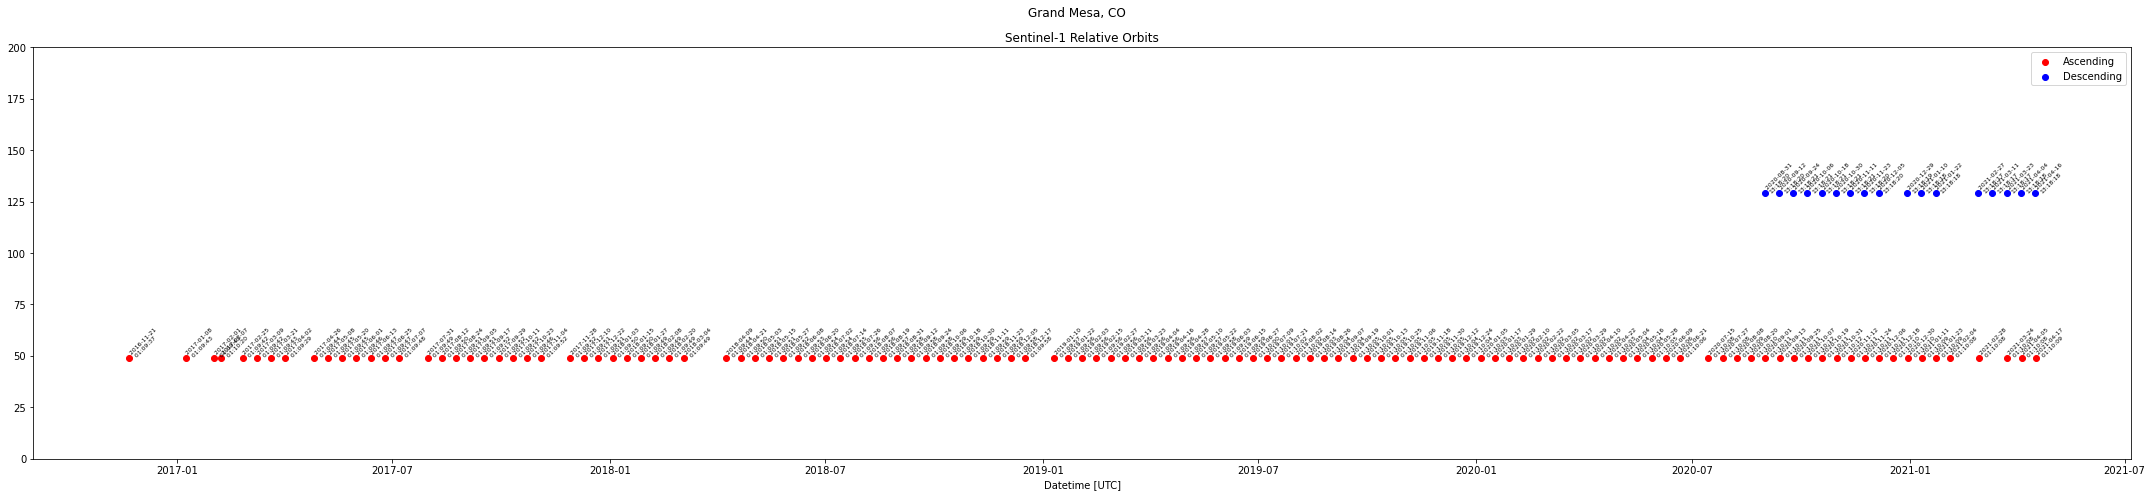

In [7]:
f,ax=plt.subplots(figsize=(30,7))
s1_rtc_bs_utils.plot_sentinel1_acquisitons(ts_ds,ax=ax,textsize=6)
f.suptitle(f'Grand Mesa, CO')
plt.tight_layout()

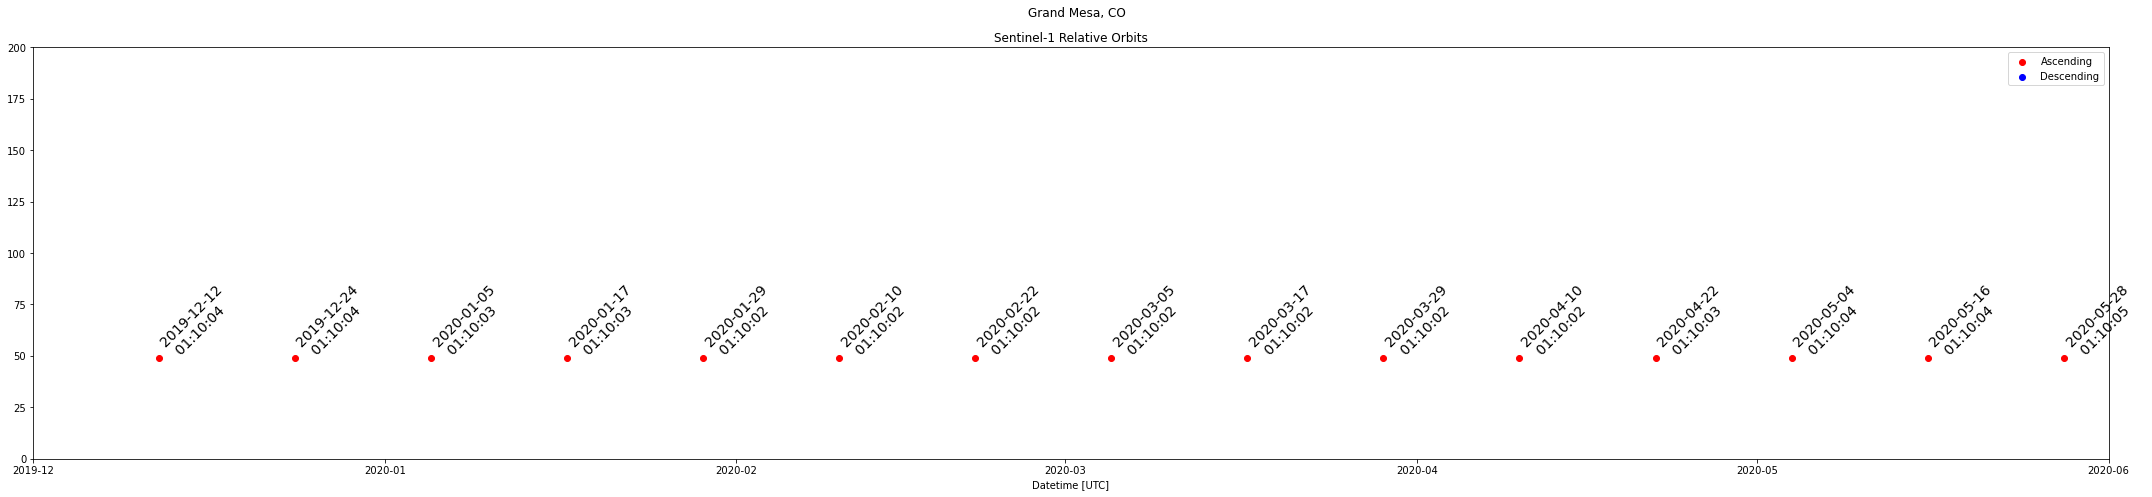

In [8]:
f,ax=plt.subplots(figsize=(30,7))
s1_rtc_bs_utils.plot_sentinel1_acquisitons(ts_ds,ax=ax,start_date='2019-12-01',end_date='2020-06-01',textsize=14)
f.suptitle(f'Grand Mesa, CO')
plt.tight_layout()
# looks like 6pm overpass?

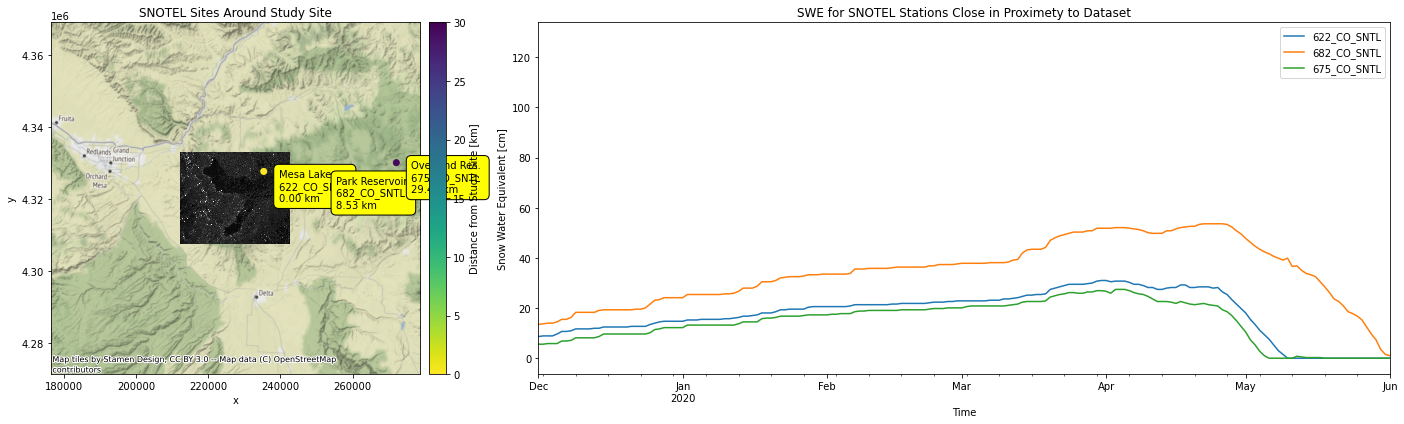

In [9]:
f,ax=plt.subplots(1,2,figsize=(20,6),gridspec_kw={'width_ratios': [1, 2]})

s1_rtc_bs_utils.plot_closest_snotel(ts_ds,distance_cutoff=30,ax=ax[0])

snotel_data = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds,variable_code='SNOTEL:WTEQ_D',distance_cutoff=30,start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
snotel_data_cm = snotel_data*2.54
snotel_data_cm.plot(ax=ax[1])

ax[1].set_xlabel('Time')
ax[1].set_ylabel('Snow Water Equivalent [cm]')
ax[1].set_title('SWE for SNOTEL Stations Close in Proximety to Dataset')
ax[1].set_xlim(['2019-12-01','2020-06-01'])

plt.tight_layout()

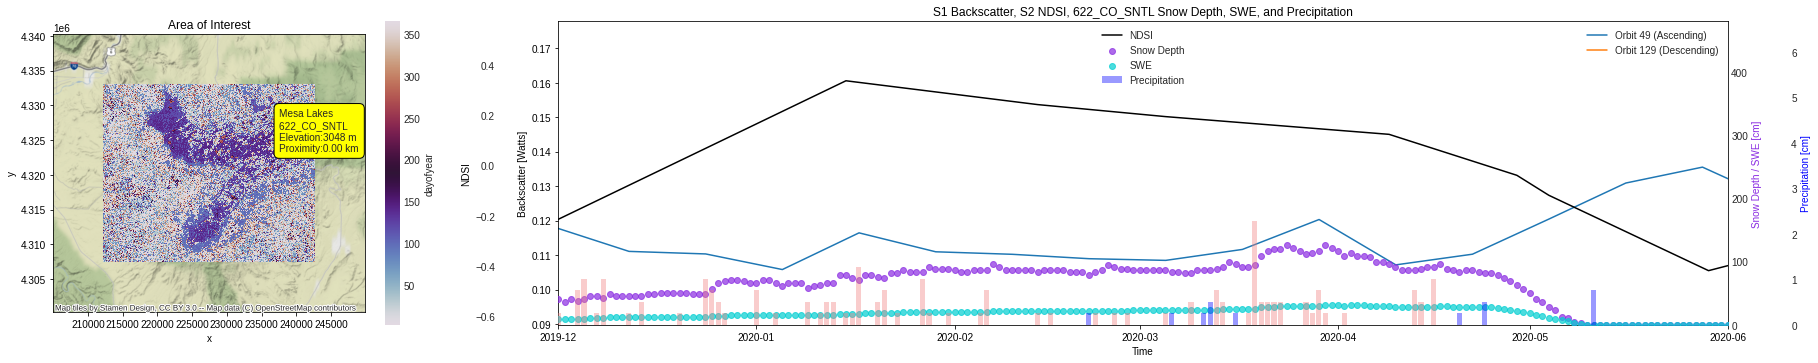

In [10]:
s1_rtc_bs_utils.plot_bs_ndsi_swe_precip_with_context(ts_ds,start_date='2019-12-01',end_date='2020-06-01')

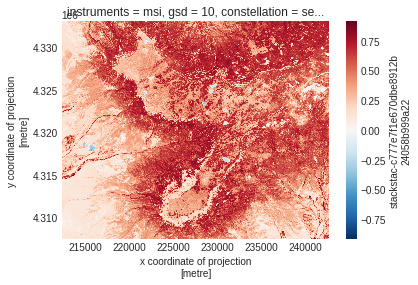

In [11]:
summer_ndvi_ds = s1_rtc_bs_utils.get_median_ndvi(ts_ds)

f,ax=plt.subplots()
summer_ndvi_ds.plot(ax=ax)

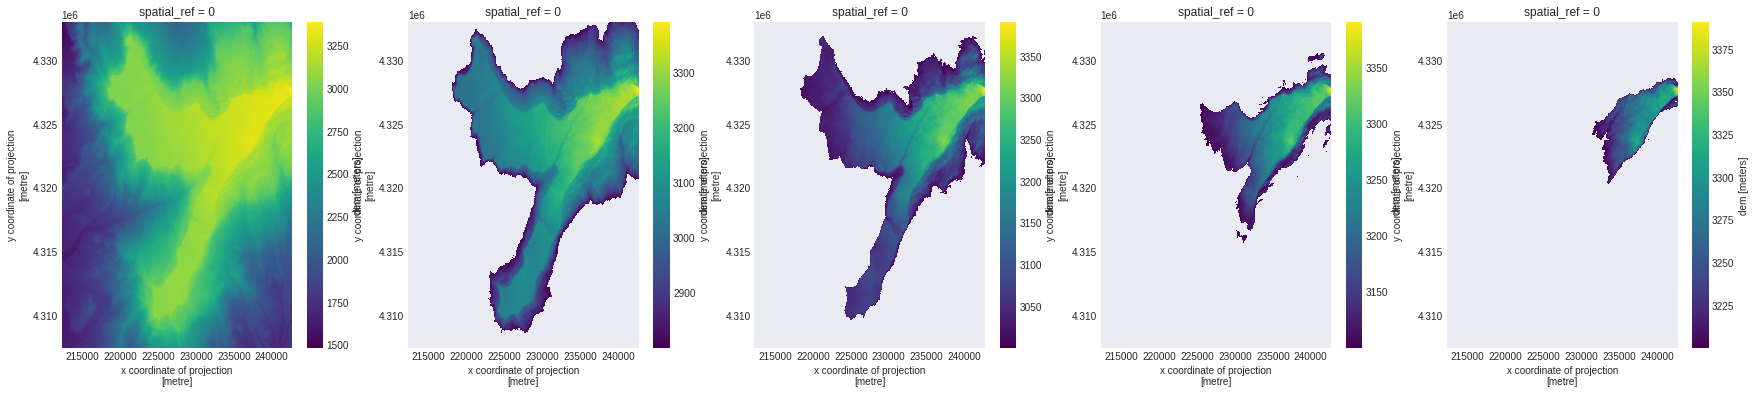

In [12]:
dem = s1_rtc_bs_utils.get_py3dep_dem(ts_ds)

f,ax=plt.subplots(1,5,figsize=(30,6))
dem.plot(ax=ax[0])
dem.where(dem>2800).plot(ax=ax[1])
dem.where(dem>3000).plot(ax=ax[2])
dem.where(dem>3100).plot(ax=ax[3])
dem.where(dem>3200).plot(ax=ax[4])

In [13]:
ts_ds_dem_masked = ts_ds.where(dem>3000)
s1_rtc_bs_utils.plot_bs_ndsi_swe_precip_with_context(ts_ds_dem_masked,start_date='2019-12-01',end_date='2020-06-01')

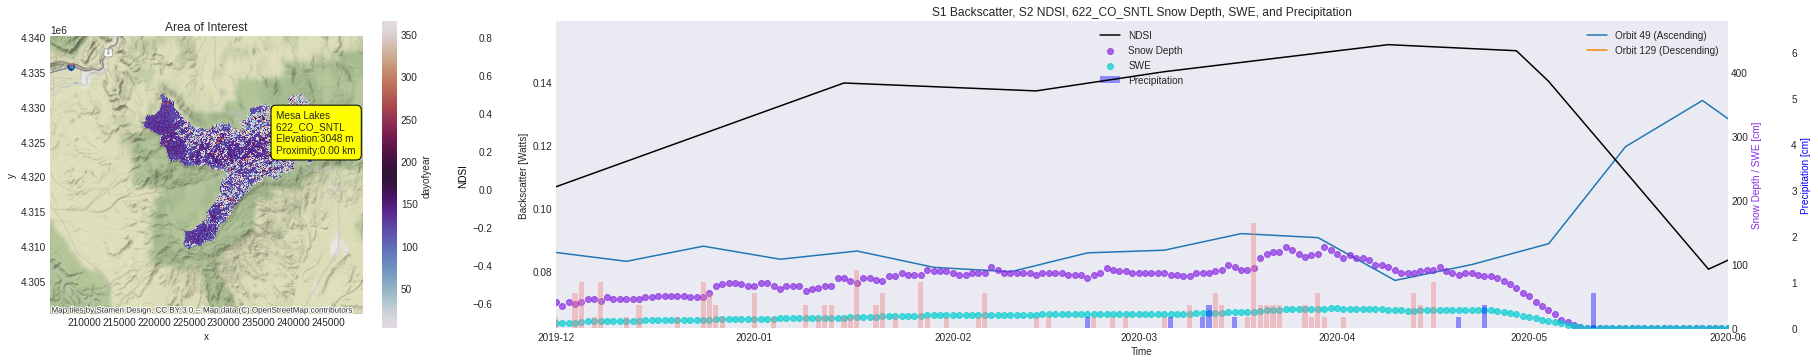

In [17]:
url = "https://gist.githubusercontent.com/meganmason/dde13c46a90875e364b1c25a31bff1d8/raw/d361e1a56eeb867bd89c87b4dc13ed431ffff6f6/SNEX_TS_SP_avg_prelim_Hackweek.geojson"
snowpits = gpd.read_file(url)

In [26]:
snowpits = snowpits[snowpits['Location']=='Grand Mesa']

In [27]:
snowpits

,State,Location,Site,PitID,Latitude,Longitude,Pit Count,Snow Class,geometry
24,CO,Grand Mesa,County Line Open,COGMCO,39.03053,-108.03220,12,2,POINT (-108.03220 39.03053)
25,CO,Grand Mesa,County Line Tree,COGMCT,39.03223,-108.03438,10,2,POINT (-108.03438 39.03223)
26,CO,Grand Mesa,Mesa West Open,COGMWO,39.03399,-108.21390,10,2,POINT (-108.21390 39.03399)
27,CO,Grand Mesa,Mesa West Trees,COGMWT,39.03282,-108.21291,7,2,POINT (-108.21291 39.03282)
28,CO,Grand Mesa,Skyway Open,COGMSO,39.04511,-108.06209,21,2,POINT (-108.06209 39.04511)
29,CO,Grand Mesa,Skyway Tree,COGMST,39.04565,-108.06333,18,2,POINT (-108.06333 39.04565)


In [28]:
snowpits = snowpits.to_crs(ts_ds.rio.crs)

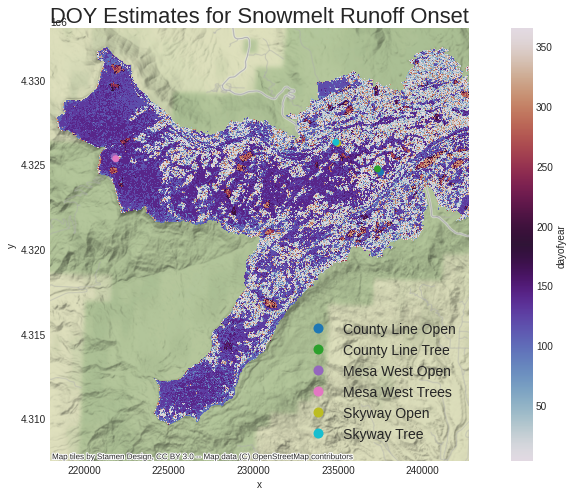

In [58]:
f,ax=plt.subplots(figsize=(12,7))
runoff_map = s1_rtc_bs_utils.get_runoff_onset(ts_ds_dem_masked).dt.dayofyear
runoff_map.plot(ax=ax,cmap='twilight')
snowpits.plot(ax=ax,categorical=True,column='Site',legend=True,legend_kwds={'bbox_to_anchor':(1.0, .35),'fontsize':14,'frameon':False})
ctx.add_basemap(ax=ax, crs=ts_ds.rio.crs, source=ctx.providers.Stamen.Terrain)
ax.set_title('DOY Estimates for Snowmelt Runoff Onset',fontsize=22)
ax.set_xlim(left=218000)
plt.tight_layout()

#ax.legend()

In [89]:
snowpits_buffer = snowpits
snowpits_buffer['geometry'] = snowpits.geometry.buffer(30)

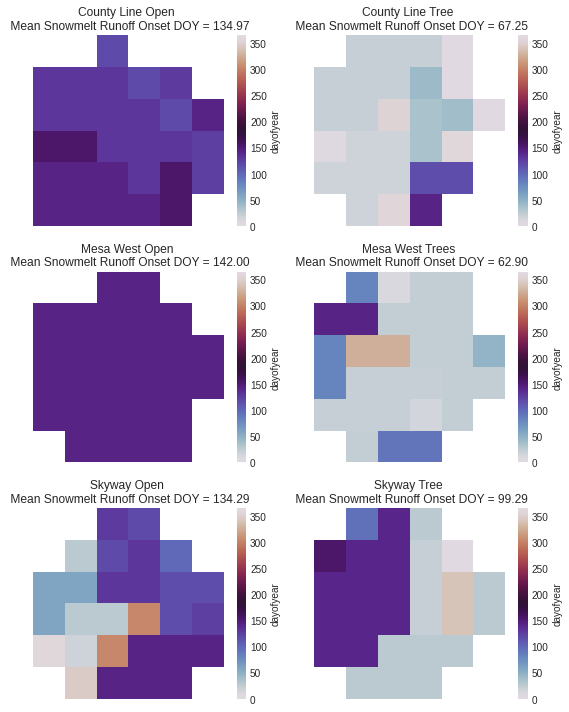

In [192]:
PitIDs = ['COGMCO','COGMCT','COGMWO','COGMWT','COGMSO','COGMST']

f,ax=plt.subplots(3,2,figsize=(8,10))

for pitid, axs in zip(PitIDs,ax.ravel()):
    snowpit = snowpits_buffer[snowpits_buffer['PitID']==pitid]
    runoff_map_clipped = runoff_map.rio.clip(snowpit.geometry)
    runoff_map_clipped.plot(ax=axs,cmap='twilight',vmin=0,vmax=365)
    axs.set_title(f'{snowpit.Site.values[0]} \n Mean Snowmelt Runoff Onset DOY = {runoff_map_clipped.mean().values:.2f}')
    axs.set_aspect('equal')
    axs.axis('off')
    #snowpits[snowpits['PitID']==pitid].plot(ax=ax)
plt.tight_layout()

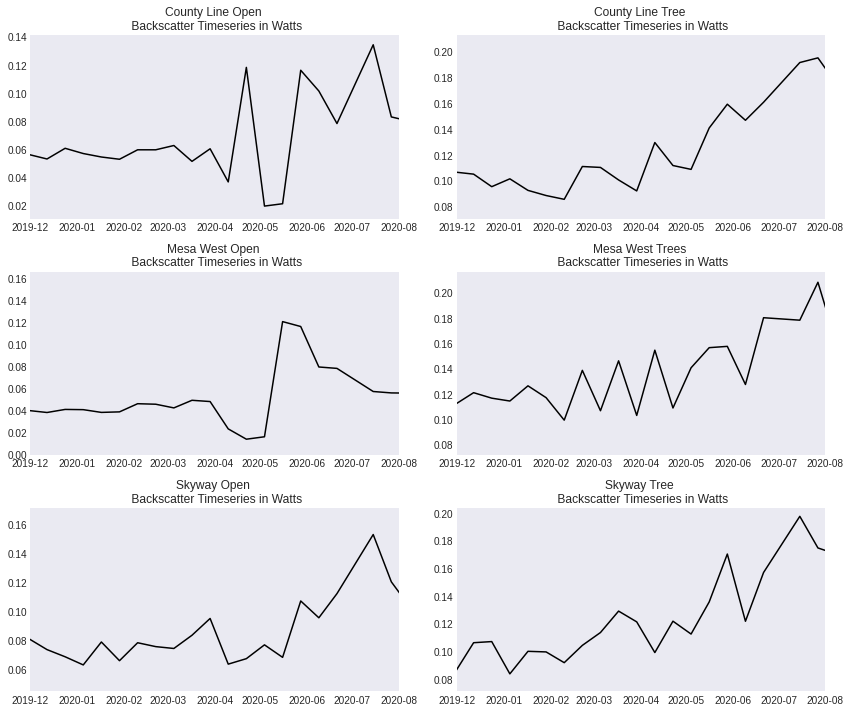

In [191]:
PitIDs = ['COGMCO','COGMCT','COGMWO','COGMWT','COGMSO','COGMST']

f,ax=plt.subplots(3,2,figsize=(12,10))

for pitid, axs in zip(PitIDs,ax.ravel()):
    snowpit = snowpits_buffer[snowpits_buffer['PitID']==pitid]
    ts_ds_clipped_site = ts_ds_dem_masked.rio.clip(snowpit.geometry)
    axs.plot(ts_ds_clipped_site.time,ts_ds_clipped_site.mean(dim=['x','y']),color='black',label='Mean Backscatter [Watts]')
    start_date = '2019-12-01'
    end_date = '2020-08-01'
    axs.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])
    
    #runoff_map_clipped.plot(ax=axs,cmap='twilight',vmin=0,vmax=365)
    axs.set_title(f'{snowpit.Site.values[0]} \n Backscatter Timeseries in Watts')
    #axs.set_aspect('equal')
    #axs.axis('off')
    #snowpits[snowpits['PitID']==pitid].plot(ax=ax)
plt.tight_layout()